In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad

import jaxley as jx
from jaxley.channels import HH
from jaxley.synapses import IonotropicSynapse, TestSynapse
from jaxley_mech.channels.fm97 import Na, K, KA, KCa, Ca, Leak

import warnings
import networkx as nx
from jaxley.connection import connect
import pandas as pd

In [4]:
dt = 0.025
t_max = 100.0
time_vec = np.arange(0, t_max+2*dt, dt)

i_delay = 10.0
i_dur = 80.0
i_amp = 5.0  # nA
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
np.random.seed(0)

In [5]:
comp = jx.Compartment()
branch = jx.Branch([comp for _ in range(4)])
cell = jx.Cell([branch for _ in range(5)], parents=jnp.asarray([-1, 0, 1, 2, 2]))
net = jx.Network([cell]*3)
connect(net[0,0,0], net[1,0,0], IonotropicSynapse())
connect(net[0,0,1], net[1,0,1], IonotropicSynapse())
connect(net[0,0,1], net[1,0,1], TestSynapse())
net.cell(2).add_to_group("cell2")
net.cell(2).branch(1).add_to_group("cell2brach1")


net.cell(0).insert(Na())
net.cell(0).insert(Leak())

net.cell(1).branch(1).insert(Na())
net.cell(0).insert(K())
net.compute_xyz()

net.cell(0).branch(0).loc(0.0).record()
net.cell(0).branch(0).loc(0.0).record("m")
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)
net.cell(0).branch(2).loc(0.0).stimulate(current)
net.cell(0).branch(1).make_trainable("Na_gNa")
net.cell(0).make_trainable("K_gK")
net.cell(1).branch("all").comp("all").make_trainable("Na_gNa", [.0,.1,.2,.3])

/home/jnsbck/Uni/PhD/projects/jaxley_project/jaxley/jaxley/modules/base.py:1432: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.pointer.edges = pd.concat(


Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 stimuli. See `.currents` for details.
Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 4. Total number of trainable parameters: 6


In [10]:
from jaxley.io.graph import from_graph

In [9]:
module = net
module.compute_xyz()
module_graph = to_graph(module)
module = from_graph(module_graph)
module_graph2 = to_graph(module)
module = from_graph(module_graph2)

NameError: name 'to_graph' is not defined

In [6]:
from jaxley.io.swc import swc_to_jaxley

In [7]:
def swc_to_graph(fname, num_lines = None, sort=True) -> nx.DiGraph:
    content = np.loadtxt(fname)[:num_lines]
    content = content[content[:, 0].argsort()] if sort else content # sort by idx
    idxs, ids, xs, ys, zs, rs, parents = content.T
    ids = ids.astype(int)
    idxs = idxs.astype(int) - 1
    root_idx = np.where(parents == -1)[0][0] # in case .swc does not start from root
    parents = parents.astype(int) - 1

    graph = nx.DiGraph() # TODO: how to handle groups? Only one per node?
    graph.add_nodes_from({i: {"x": x, "y": y, "z": z, "r": r, "id": id} for i, id, x, y, z, r in zip(idxs, ids, xs, ys, zs, rs)}.items())
    graph.add_edges_from([(node, idx) for idx, node in enumerate(parents) if idx != root_idx])
    return graph



# group_ids = {0: "undefined", 1: "soma", 2: "axon", 3: "basal", 4: "apical"}
# # Type of padded section is assumed to be of `custom` type:
# # http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html
# groups = [group_ids[id] if id in group_ids else "custom" for id in ids]

In [373]:
def dist(pre, post):
    pre_loc = np.hstack((pre["x"], pre["y"], pre["z"]))
    post_loc = np.hstack((post["x"], post["y"], post["z"]))
    return np.sqrt(np.sum((pre_loc - post_loc)**2))

def get_linear_paths(graph):
    path_edges = []
    current_path = []
    for i,j in nx.dfs_edges(graph, 0):
        current_path.append((i,j))
        is_leave_node = graph.out_degree(j) == 0 and graph.in_degree(j) == 1
        is_branching_node = graph.out_degree(j) > 1
        if is_leave_node or is_branching_node:
            path_edges.append(current_path)
            current_path = []
    return path_edges

path_e2n = lambda path: [path[0][0]]+[e[1] for e in path]
path_n2e = lambda path: [e for e in zip(path[:-1], path[1:])]

def impose_branch_structure(graph, nsegs = 4, max_branch_len = 100, append_morphology=True):
    has_loc = "x" in graph.nodes[0]
    has_rad = "r" in graph.nodes[0]
    has_id = "id" in graph.nodes[0]

    pathgraphs = []
    max_branch_idx = 0

    for i,j in graph.edges:
        graph.edges[i,j]["length"] = dist(graph.nodes[i], graph.nodes[j]) if has_loc else 1

    # segment linear sections of the graph/morphology
    linear_paths  = get_linear_paths(graph)
    for path in linear_paths:
        # get node and edge attrs
        path_nodes = path_e2n(path)
        path_node_attrs = [graph.nodes[i] for i in path_nodes]
        lengths = [graph.edges[(i,j)]["length"] for i,j in path]

        xyz = [[n[k] if has_loc else np.nan for k in "xyz"] for n in path_node_attrs]
        r = [[n["r"] if has_rad else 1.0] for n in path_node_attrs]
        xyzr = np.hstack([np.array(xyz), np.array(r)])
        ids = np.array([n["id"] if has_id else 0 for n in path_node_attrs])

        # segment morphology into branches based on nseg and max_branch_len
        pathlens = np.cumsum(np.array([0]+lengths))
        total_pathlen = pathlens[-1]
        num_branches = int(total_pathlen / max_branch_len) + 1
        
        # index branches
        branch_inds = (max_branch_idx + np.arange(num_branches).repeat(nsegs))
        max_branch_idx = branch_inds[-1] + 1
        
        # compute where to place compartment centers along morphology
        comp_len = total_pathlen / (num_branches*nsegs)
        locs = np.linspace(comp_len / 2, total_pathlen-comp_len / 2, num_branches*nsegs)
        new_nodes = np.interp(locs, pathlens, path_nodes) 
        new_nodes += 0.1*np.random.randn() # ensure unique nodes -> disjoint subgraphs 

        # interpolate xyzr and ids along the morphology
        new_xyzr = vmap(jnp.interp, in_axes=(None, None, 1))(locs, pathlens, xyzr)
        new_ids = np.interp(locs, pathlens, ids).astype(int)

        # construct graph for segemented morphology 
        keys = ["x", "y", "z", "r", "id", "branch_index"]
        new_node_attrs = zip(*new_xyzr.tolist(), new_ids, branch_inds)
        new_node_attrs = [{k:v for k,v in zip(keys, items)} for items in new_node_attrs]

        pathgraph = nx.DiGraph(path_n2e(new_nodes))
        pathgraph.add_nodes_from(zip(new_nodes, new_node_attrs))
        pathgraphs.append(pathgraph)

    # combine linear paths
    new_graph = nx.union_all(pathgraphs)

    # connect linear subgraphs according to the original graph
    linear_path_roots_leaves = np.array([(path[0][0], path[-1][-1]) for path in linear_paths])
    edges_between_linear_paths = list(zip(*np.where(np.equal(*np.meshgrid(*(linear_path_roots_leaves.T))))))
    new_edges_between_linear_paths = [(max(pathgraphs[i]), min(pathgraphs[j])) for i,j in edges_between_linear_paths]
    new_graph.add_edges_from(new_edges_between_linear_paths)

    # reconnect root
    root_edges = list(zip(*np.where([linear_path_roots_leaves[:,0] == 0])))[1:] # drop (0,0)
    new_root_edges = [(min(pathgraphs[i]), min(pathgraphs[j])) for i,j in root_edges]
    new_graph.add_edges_from(new_root_edges)

    if append_morphology:
        branch_inds = list(nx.get_node_attributes(new_graph, "branch_index").values())
        branch_membership = np.round(np.interp(graph.nodes, new_graph.nodes, branch_inds))
        morphology = np.array([[data[k] for k in "xyzr"] for i, data in graph.nodes(data=True)])
        # group morphological data by branch index
        xyzr = [morphology[branch_membership == i] for i in np.unique(branch_membership)]
        new_graph.graph["xyzr"] = xyzr
    
    # rename nodes by enumeration (since nodes idxs were interpolated)
    new_keys = {k: i for i, k in enumerate(new_graph.nodes)}
    new_graph = nx.relabel_nodes(new_graph, new_keys)
    return new_graph

In [403]:
def split_edge(graph, i, j, nsegs = 2, interpolate_node_attrs = ["x", "y", "z", "r"], interpolate_edge_attrs = ["length"]):
    new_node_inds = np.linspace(i, j, nsegs+1)
    node_attrs = np.vstack([[graph.nodes[idx][k] for k in interpolate_node_attrs] for idx in [i,j]])
    new_node_attrs = vmap(jnp.interp, in_axes=(None, None, 1))(new_node_inds[1:-1], np.array([i,j]), node_attrs).T.tolist()
    new_node_attrs = [dict(zip(interpolate_node_attrs, node)) for node in new_node_attrs]
    new_edge_attrs = [{k:graph.edges[(i,j)][k] / 2 for k in interpolate_edge_attrs}]*nsegs
    
    # remove old edge and add new edges interpolate edge attrs
    graph.add_edges_from(zip(*zip(*path_n2e(new_node_inds)), new_edge_attrs))
    graph.remove_edge(i,j)
    graph.add_nodes_from(zip(new_node_inds[1:-1], new_node_attrs))
    return graph


def impose_branch_structure(graph, max_branch_len = 100):
    has_loc = "x" in graph.nodes[0]
    has_id = "id" in graph.nodes[0]

    max_branch_idx = 0

    ids = np.array([n["id"] if has_id else 0 for i, n in graph.nodes(data=True)])
    for i,j in list(graph.edges):
        graph.edges[i,j]["length"] = dist(graph.nodes[i], graph.nodes[j]) if has_loc else 1
        if ids[i] == ids[j]:
            graph.edges[i,j]["id"] = ids[i]
        else:
            graph = split_edge(graph, i, j, 2)
            ij_mid = (i+j)/2
            graph.edges[i,ij_mid]["id"] = ids[i]
            graph.edges[ij_mid,j]["id"] = ids[j]
    
    [n.pop("id") for i, n in graph.nodes(data=True) if "id" in n]            
    new_keys = {k: i for i, k in enumerate(graph.nodes)}
    graph = nx.relabel_nodes(graph, new_keys)

    # segment linear sections of the graph/morphology
    linear_paths  = get_linear_paths(graph)
    for path in linear_paths:
        lengths = [graph.edges[(i,j)]["length"] for i,j in path]
        # segment morphology into branches based on max_branch_len and ids
        pathlens = np.cumsum(lengths)
        total_pathlen = pathlens[-1]
        num_branches = int(total_pathlen / max_branch_len) + 1
        branch_ends = np.cumsum([total_pathlen / num_branches]*num_branches)
        branch_inds = max_branch_idx + num_branches-np.sum(pathlens <= branch_ends[:, None], axis=0)
        max_branch_idx += num_branches + 1
        graph.add_edges_from(((*e,{'branch_index': branch_idx}) for e, branch_idx in zip(path, branch_inds)))
    return graph


def get_compartmentalize_branches(graph, nseg=4):
    # make every branch
    
    return graph

In [404]:
fname = "../tests/morph.swc"
graph = swc_to_graph(fname)
graph = impose_branch_structure(graph)
# cell = from_graph(graph)

In [74]:

pathlens = np.cumsum(np.array([0]+[10, 10, 10, 20, 50, 20, 100]))
total_pathlen = pathlens[-1]
num_branches = int(total_pathlen / 100) + 1

nsegs = 4
comp_len = 400 / (num_branches*nsegs)
locs = np.linspace(comp_len / 2, total_pathlen-comp_len / 2, num_branches*nsegs)
nodes = np.arange(8)

branch_inds = (0 + np.arange(num_branches).repeat(nsegs))

array([0., 0., 0., 0., 0., 1., 1., 2.])

In [127]:
xyzr = np.array([[data[k] for k in "xyzr"] for i, data in graph.nodes(data=True)])

In [192]:
# roots = np.where([graph.in_degree(n) == 0 for n in graph.nodes])[0]
# global_branch_index=0
# global_comp_index=0
# cells = []
# for r, root in enumerate(roots):
#     cell_graph = graph.subgraph(sorted(nx.single_source_shortest_path(new_graph,root)))
#     cell_graph = impose_branch_structure(cell_graph)
#     branch_index = nx.get_node_attributes(cell_graph, "branch_index")
#     cell_graph.add_nodes_from({i: {"branch_index": idx+global_branch_index} for i, idx in zip(cell_graph.nodes, branch_index)})
#     nx.set_node_attributes(cell_graph, {i:r for i in graph.nodes}, "cell_index")
#     nx.set_node_attributes(cell_graph, {i:i+global_comp_index for i in graph.nodes}, "comp_index")
#     nx.relabel_nodes(cell_graph, comp_inds)
#     global_comp_index += max(cell_graph.nodes) + 1
#     global_branch_index += max(branch_index) + 1
#     cells.append(cell_graph)
# graph = nx.union_all(cells)


In [194]:
cell_graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

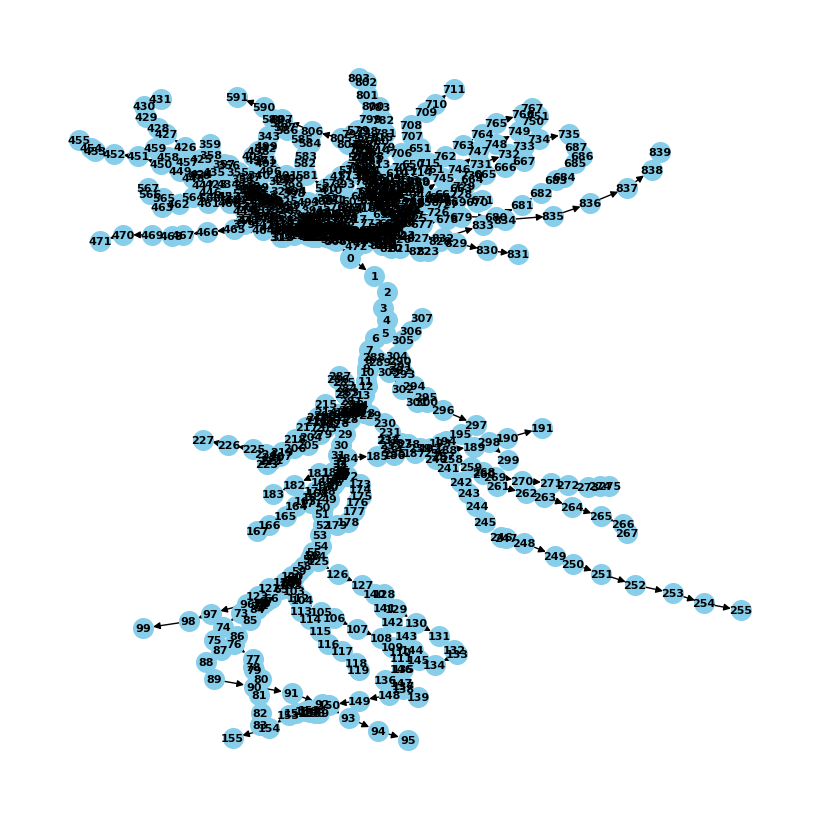

In [167]:
pos = {i: (n["x"], n["y"]) for i, n in new_graph.nodes(data=True)}
plt.figure(figsize=(8, 8))
nx.draw(new_graph, pos, with_labels=True, node_size=200, node_color="skyblue", font_size=8, font_weight="bold", font_color="black", font_family="sans-serif")
plt.show()

In [ ]:
# interpolate xyzr continously along the graph
# compute best split of the graph into compartments (groupwise?)

In [775]:
mapper = get_depth_first_branch_indexes(graph, nseg=4, return_mapper=True)
nx.set_node_attributes(graph, mapper, "branch_index")

In [15]:
from jaxley.io.graph import to_graph, from_graph, build_skeleton_module

In [115]:
edges = [(0,1),(1,2),(2,3), (3,4),(4,5),(5,6), (3,8),(8,9),(9,10)]
graph = nx.DiGraph()
graph.add_edges_from(edges)


# module = from_graph(graph)
# module.compute_xyz()
# module.vis()

In [106]:
nsegs = 4; max_branch_len = 100

pathgraphs = []
max_branch_idx = 0

for i,j in graph.edges:
    graph.edges[i,j]["length"] = 1

# segment linear sections of the graph/morphology
all_linear_paths  = get_linear_paths(graph)
for path_edges in all_linear_paths:
    # get node and edge attrs
    path_nodes = path_e2n(path_edges)
    node_attrs = [graph.nodes[i] for i in path_nodes]
    lengths = [graph.edges[(i,j)]["length"] for i,j in path_edges]
    if "x" in node_attrs[0].keys():
        xyzr = np.stack([[n[k] for k in "xyzr"] for n in node_attrs])
    else:
        xyzr = np.stack([[float("nan") for k in "xyzr"] for n in node_attrs])

    if "id" in node_attrs[0].keys():
        ids = np.array([n["id"] for n in node_attrs])
    else:
        ids = np.array([0 for n in node_attrs])

    # segment morphology into branches based on nseg and max_branch_len
    pathlens = np.cumsum(np.array([0]+lengths))
    total_pathlen = pathlens[-1]
    num_branches = int(total_pathlen / max_branch_len) + 1
    
    # index branches
    branch_inds = (max_branch_idx + np.arange(num_branches).repeat(nsegs))
    max_branch_idx = branch_inds[-1] + 1
    
    # compute where to place compartment centers along morphology
    comp_len = total_pathlen / (num_branches*nsegs)
    locs = np.linspace(comp_len / 2, total_pathlen-comp_len / 2, num_branches*nsegs)
    new_path_nodes = np.interp(locs, pathlens, path_nodes) + 0.1*np.random.randn()
    
    # interpolate xyzr and ids along the morphology
    new_xyzr = vmap(jnp.interp, in_axes=(None, None, 1))(locs, pathlens, xyzr)
    new_ids = np.interp(locs, pathlens, ids).astype(int)

    # construct graph for segemented morphology 
    keys = ["x", "y", "z", "r", "id", "branch_index"]
    new_node_attrs = zip(*new_xyzr.tolist(), new_ids, branch_inds)
    new_node_attrs = [{k:v for k,v in zip(keys, items)} for items in new_node_attrs]

    pathgraph = nx.DiGraph(path_n2e(new_path_nodes))
    pathgraph.add_nodes_from(zip(new_path_nodes, new_node_attrs))
    pathgraph.add_nodes_from(new_path_nodes)
    pathgraphs.append(pathgraph)

# combine linear paths
new_graph = nx.union_all(pathgraphs)

# connect linear subgraphs according to the original graph
linear_path_edges = np.array([(path[0][0], path[-1][-1]) for path in all_linear_paths])
edges_between_linear_paths = list(zip(*np.where(np.equal(*np.meshgrid(*(linear_path_edges.T))))))
new_edges_between_linear_paths = [(max(pathgraphs[i]), min(pathgraphs[j])) for i,j in edges_between_linear_paths]
new_graph.add_edges_from(new_edges_between_linear_paths)

# reconnect root
root_edges = list(zip(*np.where([linear_path_edges[:,0] == 0])))[1:] # drop (0,0)
new_root_edges = [(min(pathgraphs[i]), min(pathgraphs[j])) for i,j in root_edges]
new_graph.add_edges_from(new_root_edges)

# rename nodes by enumeration (since nodes idxs were interpolated)
new_keys = {k: i for i, k in enumerate(new_graph.nodes)}
new_graph = nx.relabel_nodes(new_graph, new_keys)

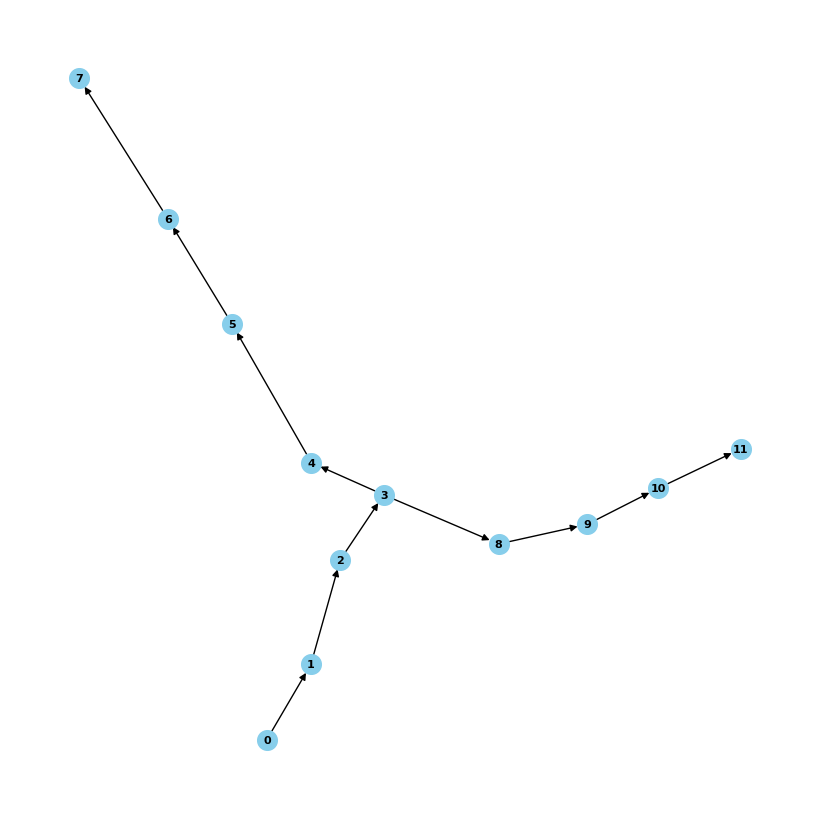

In [107]:
plt.figure(figsize=(8, 8))
nx.draw(new_graph, with_labels=True, node_size=200, node_color="skyblue", font_size=8, font_weight="bold", font_color="black", font_family="sans-serif")
plt.show()

In [512]:
# df = pd.DataFrame((net.trainable_params,net.indices_set_by_trainables, []), index=["param", "index", "value"])
# df = df.T.explode("index").explode("index").reset_index(drop=True)
# split_col = df["param"].apply(lambda d: next(iter(d.items())))
# df[["param", "value"]] = pd.DataFrame(split_col.tolist())
# df = df.astype({"index": int, "value": float, "param": str})
# trainable_iter = {i: {k:np.array([v]) for i,(k,v) in group[["param", "value"]].iterrows()} for i,group in  df.groupby("index")}

In [479]:
# trainable_inds = np.unique(np.hstack(net.indices_set_by_trainables))
# trainable_params = {i:{} for i in trainable_inds}
# for i in trainable_inds:
#     for inds, params in zip(net.indices_set_by_trainables, net.trainable_params):
#         if i in inds.flatten():
#             trainable_params[i].update(params)
# trainable_iter = {k:{"trainables":v} for k,v in trainable_params.items()}
# module_graph.add_nodes_from(trainable_iter.items())

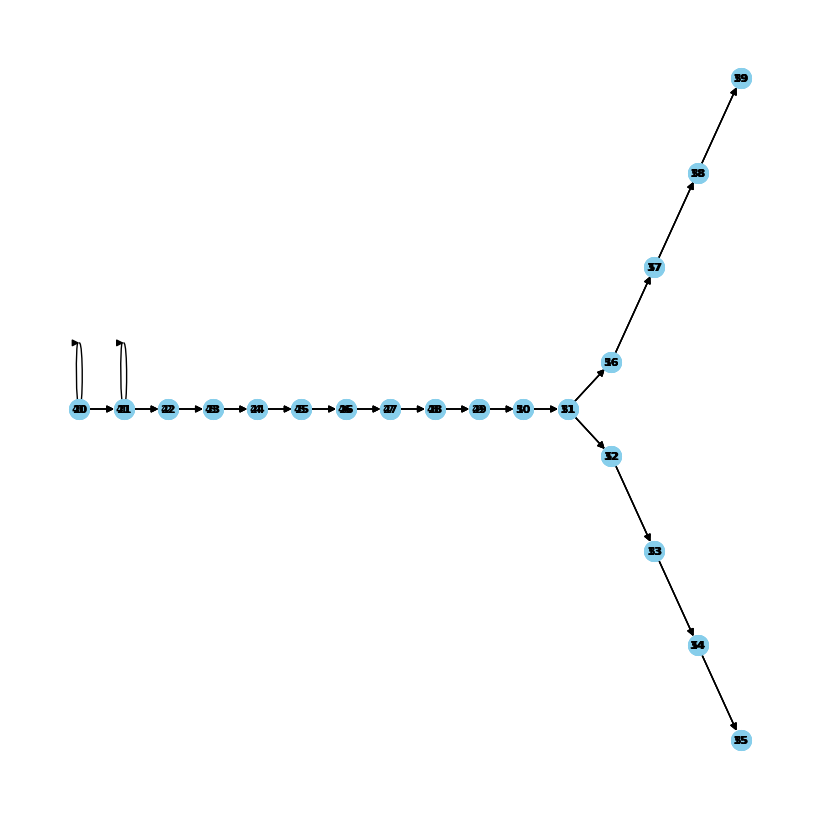

In [23]:
# plot the graph
pos = {i: (n["x"], n["y"]) for i, n in module_graph.nodes(data=True)} 
plt.figure(figsize=(8, 8))
nx.draw(module_graph, pos, with_labels=True, node_size=200, node_color="skyblue", font_size=8, font_weight="bold", font_color="black", font_family="sans-serif")
plt.show()

In [ ]:
# # since the original xyzr is not known, one cannot know where xyzr was measured
# # and where it was interpolated. Therefore, original.xyzr and from_graph.xyzr
# # will probably differ.
# if "x" in nodes.columns:
#     # interpolate xyzr between first and last only
#     first_branch_inds = nodes.reset_index().groupby("branch_index").first()["index"].values
#     last_branch_inds = nodes.reset_index().groupby("branch_index").last()["index"].values
#     first_xyzr = nodes.loc[first_branch_inds][["x", "y", "z", "radius"]]
#     last_xyzr = nodes.loc[last_branch_inds][["x", "y", "z", "radius"]]
#     dl = last_xyzr[["x", "y", "z"]].values - first_xyzr[["x", "y", "z"]].values
#     first_xyzr[["x", "y", "z"]] = first_xyzr[["x", "y", "z"]]-1/2*dl/(module.nseg-1)
#     last_xyzr[["x", "y", "z"]] = last_xyzr[["x", "y", "z"]]+1/2*dl/(module.nseg-1)
#     xyzr = [np.vstack([first, last]) for first, last in zip(first_xyzr.values, last_xyzr.values)]

### Ideas:
- add a `groups` property
- show group membership in nodes
- make use to to_graph in plotting
- make use of from graph in swc import
- modules can be saved as graph, no need for pickle necessarily
- prevent untrainable stuff, like `Na` from being made trainable!
- Do we really want to enforce nsegs equal? is it required?